In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colours
from enum import Enum
import time
from copy import copy

# Only used for animating the pathfind
from IPython.display import clear_output

seed = 0
np.random.seed(seed)

In [2]:
# The Grid class
# Reason for creating the Grid class is so that I can use "id" as key in dictionary rather than converting the coord to string
class Grid:

    def __init__(self, x_size, y_size, low, high):
        self.size = x_size * y_size
        self.x_size = x_size
        self.y_size = y_size
        self.grid = np.random.randint(low, high=high+1, size=(1, self.size))[0]
        self.high = high

    # returns the left cell
    def get_left_cell(self, id):
        lid = id-1
        if id >= 0 and id % self.x_size != 0:
            return (lid, self.grid[lid])

    # returns the right cell
    def get_right_cell(self, id):
        lid = id+1
        if id < self.size and (lid) % self.x_size != 0:
            return (lid, self.grid[lid])

    # returns the top cell
    def get_top_cell(self, id):
        lid = id-self.x_size
        if lid >= 0:
            return (lid, self.grid[lid])

    # returns the bottom cell
    def get_bottom_cell(self, id):
        lid = id+self.x_size
        if lid < self.size:
            return (lid, self.grid[lid])

    # returns the cell weight
    def get_cell_weight(self, id):
        return self.grid[id]
    
    # returns a cell's neighbours
    def get_neighbours(self, id):
        n = []

        # get neighbours
        left = self.get_left_cell(id)
        right = self.get_right_cell(id)
        top = self.get_top_cell(id)
        bot = self.get_bottom_cell(id)

        # append neighbours if available
        if left:
            n.append(left[0])
        if right:
            n.append(right[0])
        if top:
            n.append(top[0])
        if bot:
            n.append(bot[0])
        return n

    # returns neighbours of every cell
    def get_relations(self):
        r = []
        for i in range(self.size):
            n = self.get_neighbours(i)
            r.append(n)
        return r

    # target id
    def get_target_id(self):
        return len(self.grid)-1

    # converts id to coordinates (y,x)
    def id_to_coord(self, id):
        y = id // self.y_size
        x = id % self.x_size
        return (y,x)

    # pretty prints grid
    def spit_grid(self):
        print(self.grid.tolist())

In [3]:
# Visualisation
class GridColour(Enum):
    PLAIN = 0
    PATH = 2
    START = 3
    TARGET = 4

class AnimationController:
    def __init__(self, grid: Grid, animation_speed):
        self.grid = grid.grid
        self.x_size = grid.x_size
        self.y_size = grid.y_size
        self.animation_speed = animation_speed

        # create grid fig and show
        self.title = f"Generated Grid of size {self.x_size} x {self.y_size}, with Seed {seed} and 'n_value' of {grid.high}"
        self.colour_grid = np.zeros((self.y_size, self.x_size))

    # creates the grid
    def gridshow(self):

        # creating coloured grid
        fig, axes = plt.subplots(figsize=(self.x_size/2 if self.x_size < 40 else 20, self.y_size/2 if self.y_size < 40 else 20))
        axes.set_axis_off()
        axes.matshow(self.colour_grid)

        # setting text
        for (y, x), z in np.ndenumerate(self.grid.reshape(self.y_size, self.x_size)):
            axes.text(x, y, z, fontsize='xx-large' if self.grid.size < 40*40 else 'xx-small', color='white', ha='center', va='center')

        # show plot
        axes.set_title(self.title, fontsize='x-large')
        plt.show()

    # update the grid colours in grid colour of a cell
    def update_grid_colour(self, id, colour: GridColour):
        x = id % self.x_size
        y = id // self.x_size
        self.colour_grid[y][x] = colour.value

    def step(self, id, colour: GridColour):
        self.update_grid_colour(id, colour)
        if self.animation_speed == 0:
            return
        clear_output(wait=True)
        time.sleep(self.animation_speed)
        self.gridshow()


In [4]:
# Heuristic Algorithm Class
class HeuristicAlgorithm():

    def __init__(self, grid, animation: AnimationController):
        self.grid = grid
        self.memory = {0: (grid.get_cell_weight(0), None)}  # {point: [weight_from_origin, previous_point]}
        self.queue = [0]
        self.animation = animation
        self.gamemode = 0

    # Help find the algorithm
    def find_shortest_path(self, gamemode):

        self.gamemode = gamemode

        # Step
        while len(self.queue) > 0:

            # get next point in queue
            vis = self.q_get()
            vis_mem = self.mem_get_point(vis)

            # add right side to memory and queue
            right = self.grid.get_right_cell(vis)
            if right:
                self.mem_update_point(right, vis, vis_mem[0])
                if right[0] != self.grid.size-1:
                    self.q_enqueue(right[0])

            # add left side to memory and queue
            bottom = self.grid.get_bottom_cell(vis)
            if bottom:
                self.mem_update_point(bottom, vis, vis_mem[0])
                if bottom[0] != self.grid.size-1:
                    self.q_enqueue(bottom[0])

    # Backtrack -> returns path in reverse
    def backtrack_path(self):

        # init target info
        target_cell = self.grid.size-1
        ptr = self.mem_get_point(target_cell)

        # anim
        self.animation.step(target_cell, GridColour.TARGET)

        # start from target [bottom right] backtrack via 'prev'
        while ptr[1]:
            ptr = self.mem_get_point(ptr[1])
            self.animation.step(ptr[1], GridColour.PATH)
        self.animation.step(0, GridColour.START)

    # Helper functions
    def q_enqueue(self, c):
        self.queue.append(c)

    def q_get(self):
        next_q = copy(self.queue[0])
        self.queue.pop(0)
        return next_q

    def mem_get_point(self, k):
        if k in self.memory:
            return self.memory[k]

    def mem_update_point(self, cell, prev_id, prev_weight):
        
        # calculating the weight based on the gamemode
        if self.gamemode == 0:
            wfo = prev_weight+cell[1]
        elif self.gamemode == 1:
            wfo = prev_weight+abs(prev_weight-cell[1])
        
        # get cell
        point = self.mem_get_point(cell[0])

        # if a point is not in memory or the wfo is less than current path -> add/replace point
        if point is None or wfo < point[0]:
            self.memory[cell[0]] = (wfo, prev_id)


In [5]:
# Dijkstra Algorithm Class
class DijkstraAlgorithm:
    
    def __init__(self, grid, animation: AnimationController):

        self.animation = animation
        self.grid_costs = grid.grid
        self.grid_size = grid.size
        self.relations_graph = grid.get_relations()
        self.cost_table = None

        # create and set cost_table
        self.gen_cost_table()
    
    def gen_cost_table(self):

        # [ cost from origin, previous vertext ]  ->  -1 = infinity/not set
        self.cost_table = np.array([np.zeros(self.grid_size)-1, np.zeros(self.grid_size)-1], dtype='int64')
        self.cost_table[0][0] = self.grid_costs[0]
        self.cost_table[1][0] = 0

    # pathfinding
    def find_shortest_path(self, gamemode):

        # visit nodes
        for node_id in range(self.grid_size):

            visit_node_cost = self.cost_table[0][node_id]
            
            # update neighbours cost
            for neighbor_id in self.relations_graph[node_id]:
                neighbour_cost = self.grid_costs[neighbor_id]
                neighbour_cost_from_origin = self.cost_table[0][neighbor_id]

                # calculating the cost based on the gamemode
                if gamemode == 0:
                    from_visit_cost = visit_node_cost+neighbour_cost
                elif gamemode == 1:
                    from_visit_cost = visit_node_cost+abs(visit_node_cost-neighbour_cost)

                # update cost table -> if infinity or less than current saved cost from origin
                if neighbour_cost_from_origin < 0 or from_visit_cost < neighbour_cost_from_origin:
                    self.cost_table[0][neighbor_id] = from_visit_cost  # update from origin cost
                    self.cost_table[1][neighbor_id] = node_id  # update previous node id

        # returns total cost amount
        return self.cost_table[0][self.grid_size-1]

    def backtrack_path(self):
        node_id = self.grid_size-1
        self.animation.title = f'Shortest Path cost: {self.cost_table[0][node_id]}'
        self.animation.step(node_id, GridColour.TARGET)

        while node_id != 0:
            node_id = self.cost_table[1][node_id]  # get the previous node_id
            self.animation.step(node_id, GridColour.PATH if node_id != 0 else GridColour.START)

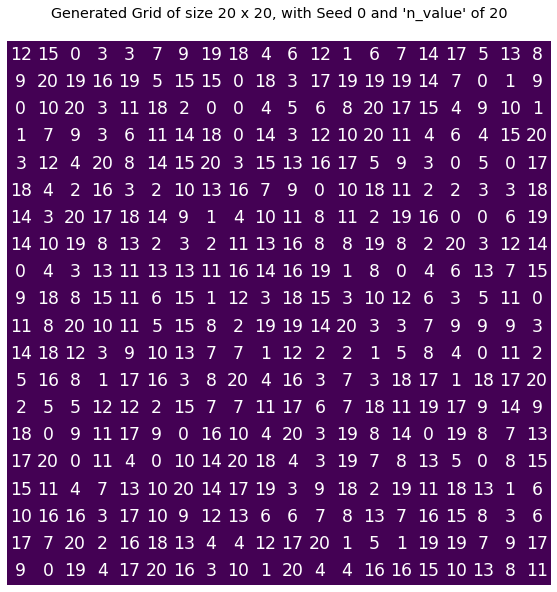

In [6]:
size = input('Please enter the Grid Size (eg 10x10)')
n_value = int(input('Please enter the cell n_value'))
x_size, y_size = size.split('x')
grid = Grid(int(x_size), int(y_size), 0, n_value)

gamemode = int(input('Please enter the Gamemode \n (1 for time spent on a cell is the number on this cell or 2 for time spent on a cell is the absolute of the difference between the previous cell the agent was on and the current cell it is on)'))

anim_speed = input('Press enter to continue without animation, otherwise enter wait time')
anim_speed = int(anim_speed) if anim_speed != '' else 0
anim = AnimationController(grid, anim_speed)

algo = input("Press enter to use Dijkstra's Algorithm, otherwise enter 'H' for Heuristic [slow]")
algo = HeuristicAlgorithm(grid, anim) if algo == 'H' else DijkstraAlgorithm(grid, anim)

anim.gridshow()

In [7]:
algo.find_shortest_path(gamemode-1)

220

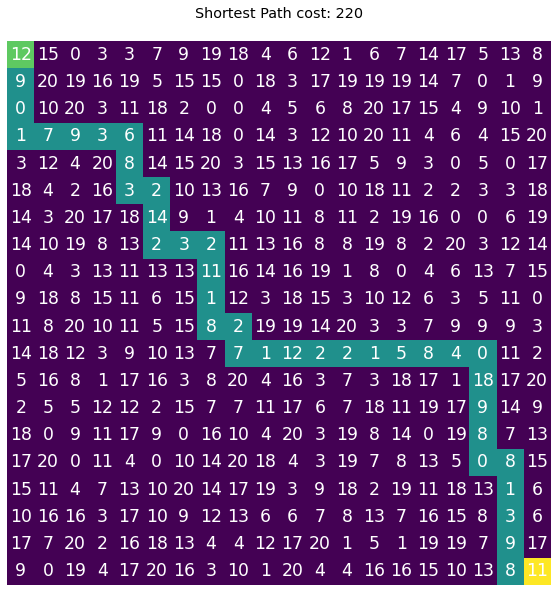

In [8]:
algo.backtrack_path()
if anim_speed == 0:
    anim.gridshow()

## Analysis

Variance of n_value

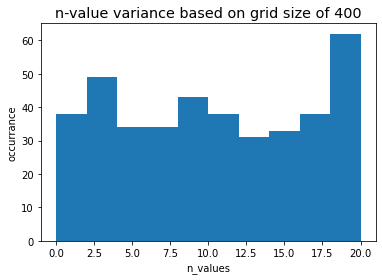

In [9]:
plt.hist(grid.grid)
plt.xlabel('n_values')
plt.ylabel('occurrance')
plt.title(f'n-value variance based on grid size of {grid.size}', fontsize='x-large')
plt.show()

Parameters Change

In [10]:
# grid config
np.random.seed(0)  # reset seed
n_value = 10
x_size, y_size = 10, 10

# amount
period = 10
start = 5
step = 3

Visualize

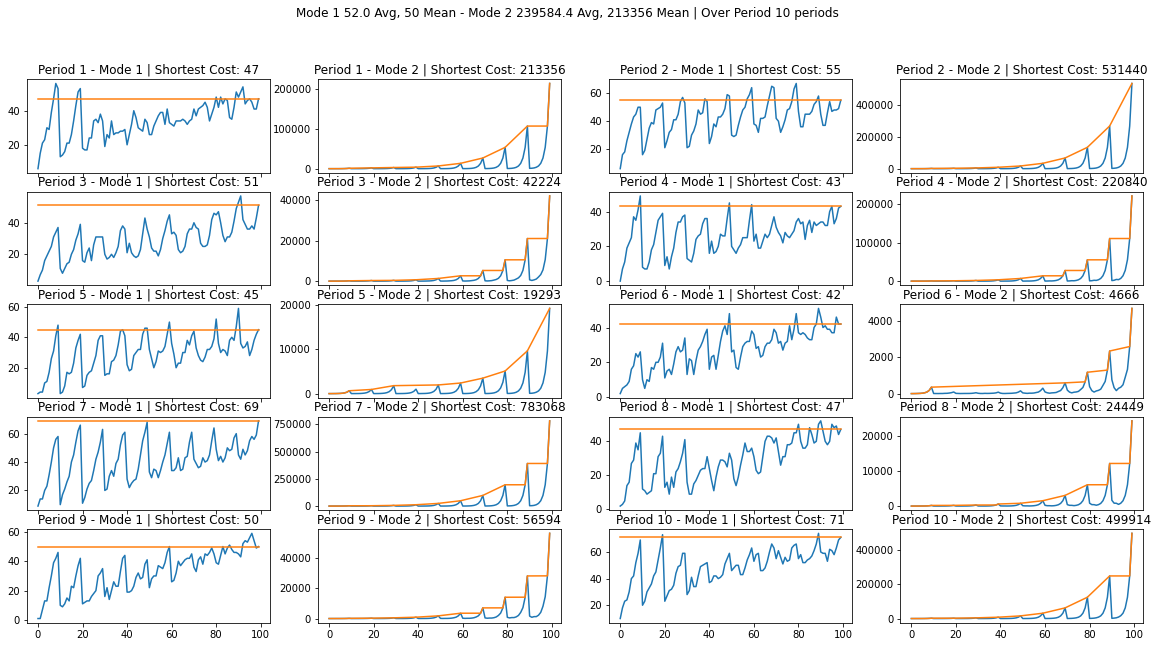

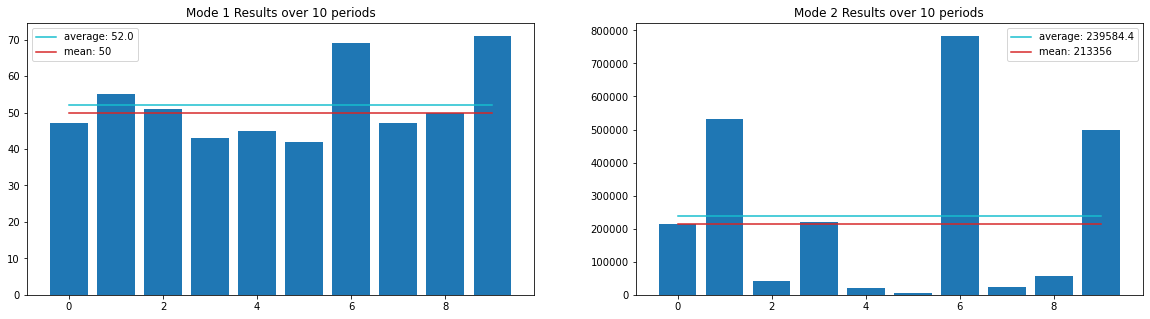

In [12]:
cost_amounts_1 = np.zeros(period, dtype='int64')
cost_amounts_2 = np.zeros(period, dtype='int64')

fig, axes = plt.subplots(n_value//2, 4, figsize=(20, 10), sharex=True)
axes = axes.ravel()

# run algo
for i, axi in enumerate(range(0, period*2, 2)):
    grid = Grid(x_size, y_size, 0, n_value)
    algo = DijkstraAlgorithm(grid, AnimationController(grid, 0))

    # find path and show costs
    cost = algo.find_shortest_path(0)
    cost_amounts_1[i] = cost
    axes[axi].set_title(f'Period {i+1} - Mode 1 | Shortest Cost: {cost}')
    axes[axi].plot(algo.cost_table[0])
    axes[axi].plot([0, grid.size-1], [cost, cost])

    # reset cost table
    algo.gen_cost_table()
    
    cost = algo.find_shortest_path(1)
    cost_amounts_2[i] = cost
    axes[axi+1].set_title(f'Period {i+1} - Mode 2 | Shortest Cost: {cost}')
    axes[axi+1].plot(algo.cost_table[0])

    grid_line_x, grid_line_y = [], []
    for i in range(grid.size):
        wait_time = algo.cost_table[0][i]
        if len(grid_line_y) == 0 or wait_time > grid_line_y[-1]:
            grid_line_x.append(i)
            grid_line_y.append(wait_time)
    axes[axi+1].plot(grid_line_x, grid_line_y)

# average & mean mode 1
avg1 = np.average(cost_amounts_1)
cm1sort = np.sort(cost_amounts_1)
mean1 = cm1sort[cm1sort.size//2]

# average & mean mode 2
avg2 = np.average(cost_amounts_2)
cm2sort = np.sort(cost_amounts_2)
mean2 = cm2sort[cm2sort.size//2]

# title
fig.suptitle(f'Mode 1 {avg1} Avg, {mean1} Mean - Mode 2 {avg2} Avg, {mean2} Mean | Over Period {period} periods')

# display
plt.show()

# display average and mean
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
period_range = range(period)

# mode 1 show
axes[0].set_title(f'Mode 1 Results over {period} periods')
axes[0].bar(period_range, cost_amounts_1)
l1, = axes[0].plot([0, period-1], [avg1, avg1], 'tab:cyan', label=f'average: {avg1}')
l2, = axes[0].plot([0, period-1], [mean1, mean1], 'tab:red', label=f'mean: {mean1}')
axes[0].legend(handles=[l1, l2])

# mode 2 show
axes[1].set_title(f'Mode 2 Results over {period} periods')
axes[1].bar(period_range, cost_amounts_2)
l1, = axes[1].plot([0, period-1], [avg2, avg2], 'tab:cyan', label=f'average: {avg2}')
l2, = axes[1].plot([0, period-1], [mean2, mean2], 'tab:red', label=f'mean: {mean2}')
axes[1].legend(handles=[l1, l2])

# display
plt.show()